# Lane detection with OpenCV

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Edge detection - Canny edge

The goal of edge detection is to identify the edges of objects inside images. This is done by identiying strong gradients. A gradient is a sharp changes in brightness over adjacent pixels. 

<ins>Steps</ins>
1. Grayscale
    - easier to compute
2. Gaussian Blur
    - idea is to take the surrounding pixels & average their colors out
    - reduces noise
3. Canny
    - detect edges
    - images can be seen as pixel values on a x & y axis (0 = black, 255 = white)
        - can be mathematically expressed as $f(x, y)$
        - the derivative ($f'(x, y)$) can be used to measure the intensity of changes between pixels
        - the strongest changes / gradients will be displayed as white lines 

![Canny Edge](img/lane_detection/canny_edge.jpg)

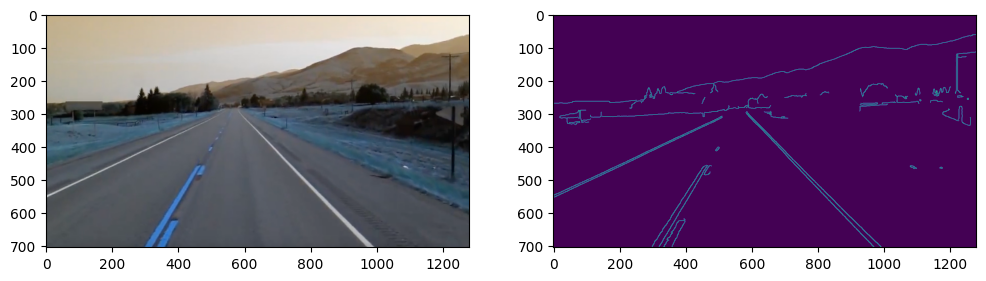

In [12]:
image = cv2.imread("img/lanes_img.jpg")
img = np.copy(image)

# 1. grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. gaussian blur
# 5x5 kernel
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# 3. canny
canny = cv2.Canny(blur, 50, 150)

_, axarr = plt.subplots(1, 2, figsize=(12, 12))
axarr[0].imshow(img)
axarr[1].imshow(canny)
plt.show()

## Region of Interest

After identifying the edges it's time to define the region of interest where the neural network should look to find the lanes.

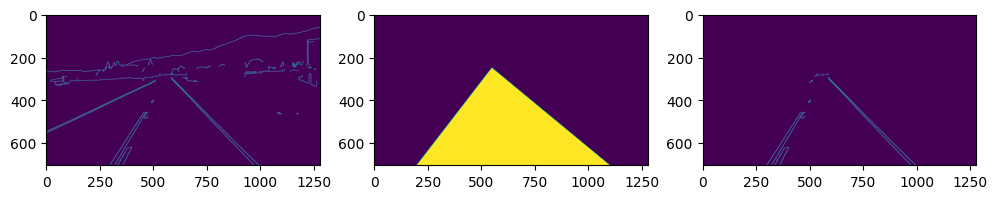

In [17]:
height = canny.shape[0]
roi = np.array([[200, height], [1100, height], [550, 250]])
mask = np.zeros_like(canny)
cv2.fillPoly(mask, [roi], 255)
masked_img = cv2.bitwise_and(canny, mask)

_, axarr = plt.subplots(1, 3, figsize=(12, 12))
axarr[0].imshow(canny)
axarr[1].imshow(mask)
axarr[2].imshow(masked_img)
plt.show()

## Hough Transform

Hough Transform is used to detect straight lines in an image.

![Hough Transform](img/lane_detection/hough_transform.png)

In a x,y coordinate system ($(x, y)$) a straight line can be represented as $y = mx + b$. For a given straight line you can also plot "m" and "b" as a point (2D vector) in Hough space. If multiple straight lines pass through the same point in a coordinate space and are plotted in Hough space, they form a straight line there. The intersection point of two lines in HS give the "m" and "b" values for a straight line that connects the two points in CS.

![Hough Transform](img/lane_detection/hough_line_detection.png)

HS can be seperated into a grid. If you want to detect the best fitting line you can find the grid cell with most intersections and take this "m" and "b" values to draw the line.

<ins>Problem</ins><br>
$y = mx +b$ can't represent vertical lines. So instead of representing lines in a "Catesian cooridnate system" we can represent them in a "Polar  cooridnate system". In the "Polar coordinate system" points are based on radius and angle ($(r, \theta)$). Using polar coordiantes lead to sinusoidal curves in HS but the concept of intersection still remainds the same.

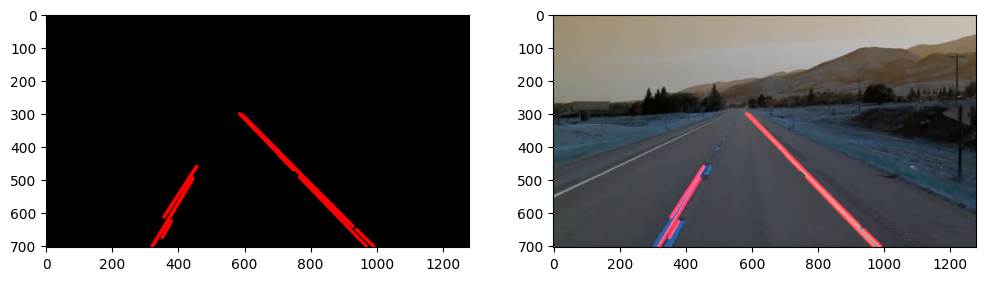

In [22]:
# 2, 1 defines the grid cell size
# 100 is the threshold for interesections inside a cell
lines = cv2.HoughLinesP(masked_img, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)

line_img = np.zeros_like(img)
if line_img is not None:
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 0), 10)

# combine images
comb_img = cv2.addWeighted(image, 0.8, line_img, 1, 1)

_, axarr = plt.subplots(1, 2, figsize=(12, 12))
axarr[0].imshow(line_img)
axarr[1].imshow(comb_img)
plt.show()